# Expectation Maximization

The current demo illustrates how to set up an expectation maximization algorithm with ForneyLab. We will consider a univariate state-space model of the following form:
\begin{align*}
    x_t &\sim \mathcal{N}(x_{t-1}, u)\\
    y_t &\sim \mathcal{N}(x_t, v)\,,
\end{align*}
where we are interested in estimating the transition variance $u$ through the expectation maximization (EM) algorithm. The EM algorithm requires the definition of two steps. First, the expectation step will compute the expectation as a function of $u$. This step will be executed by message passing on the factor graph. Then, the Maximization step will find the value $\hat{u}$ that maximizes this expectation. This step will be custom defined.

We start by generating a toy dataset.

In [1]:
using PyPlot
using ForneyLab
using Optim

# Data
T = 50 # Number of datapoints
u_data = 0.04 # Transition model variance
v_data = 0.1 # Observation model variance
x_0_data = 0.0 # Initial state

# Initialize state end observation vectors
x_data = Vector{Float64}(undef, T)
y_data = Vector{Float64}(undef, T)

# Generate data
x_t_min_data = x_0_data
for t = 1:T
    x_data[t] = x_t_min_data + sqrt(u_data)*randn()
    y_data[t] = x_data[t] + sqrt(v_data)*randn()
    
    x_t_min_data = x_data[t] # Reset state
end
;

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1273


# Model specification

The model is specified with a parameter `u[t]` that at each timepoint is clamped to a specific value that will be available from the `data` dictionary at `data[:u]`. During inference, this value will be iterativaly updated by the Maximization step.

In [2]:
g = FactorGraph()

# State prior
@RV x_0 ~ GaussianMeanVariance(0.0, 10.0)

x = Vector{Variable}(undef, T)
u = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

x_t_min = x_0
for t = 1:T
    @RV u[t] ~ placeholder(:u) # Parameter placeholder
    @RV x[t] ~ GaussianMeanVariance(x_t_min, u[t]) # Transition model
    @RV y[t] ~ GaussianMeanVariance(x[t], v_data) # Observation model

    # Data placeholder
    placeholder(y[t], :y, index=t)
    
    # Reset state for next step
    x_t_min = x[t]
end

# Algorithm generation

Now we generate an algorithm that passes messages towards the latent state, as well as the parameter of interest `u`.

In [3]:
algo = sumProductAlgorithm([x; u])
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code))
;

When we print the algorithm code, we see that ForneyLab warns us that we are trying to infer a clamped parameter, and suggests that we define a maximizer function `optimize!()`. This function should accept the current messages and parameters and edit the `data` dictionary with the newly inferred parameter value. The relevant messages are indicated by the `init()` function.

In [4]:
println(source_code[7:530])
println("...")


# You have created an algorithm that requires updates for (a) clamped parameter(s).
# This algorithm requires the definition of a custom `optimize!` function that updates the parameter value(s)
# by altering the `data` dictionary in-place. The custom `optimize!` function may be based on the mockup below:

# function optimize!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=init())
# 	...
# 	return data
# end

function init()

messages = Array{Message}(undef, 298)

messages[249] = Message(vague(Function))
...


We define the `optimize!()` function to use a numerical optimizer to maximize the log-pdf.

In [5]:
function optimize!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=init())
    # Construct the objective function (to minimize)
    negLogPdf(x) = -sum([messages[i].dist.params[:log_pdf](x) for i=249:298])
    
    res = optimize(negLogPdf, 0.1, 10.0) # Numerical optimization
    data[:u] = res.minimizer # Update data dictionary with the new estimate
        
    return data
end
;

# Algorithm execution

In [6]:
data = Dict(:y => y_data,
            :u => 1.0) # Initialize the parameter value
marginals = Dict()
messages = init() # Initialize the messages in the present scope

for i=1:10
    step!(data, marginals, messages)
    optimize!(data, marginals, messages)
end
;

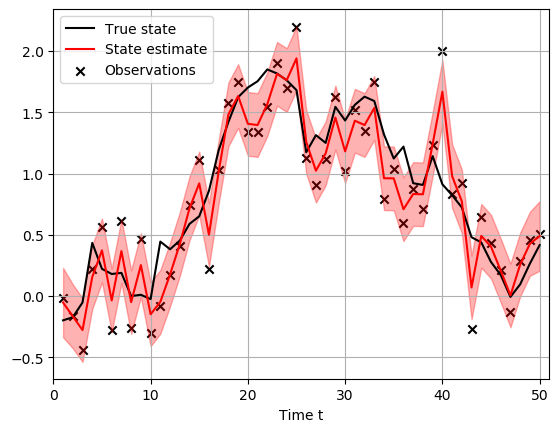

In [7]:
x_est = [marginals[:x_*t] for t=1:T]
m_x_est = [ForneyLab.unsafeMean(x_est[t]) for t=1:T]
v_x_est = [ForneyLab.unsafeVar(x_est[t]) for t=1:T]

scatter(1:T, y_data, color="black", marker="x", label="Observations")
plot(1:T, x_data, color="black", label="True state")
plot(1:T, m_x_est, color="red", label="State estimate")
fill_between(1:T, m_x_est - sqrt.(v_x_est), m_x_est + sqrt.(v_x_est), color="red", alpha=0.3)
xlabel("Time t")
grid("on")
legend()
xlim(0, T+1)
;

In [8]:
println("The maximum likelihood estimate for the transition variance is: $(data[:u])")

The maximum likelihood estimate for the transition variance is: 0.3344792890880953
